In [1]:
import pandas as pd
import numpy as np
import cPickle as pickle
from test import *
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier, LogisticRegression
from collections import Counter
import seaborn as sns
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import euclidean_distances

Read in the data and split off labels 

In [2]:
math_df = pd.read_pickle('general_math_text_titles_urls_label_df.pkl')
text_data = math_df['text'].values
targets = math_df['label'].values
text_data = list(text_data)
text_data = clean_pdf_text(text_data) #The clean_pdf_text function takes a list as input
text_data = np.array(text_data)

Make the model

In [3]:
tfidf = TfidfVectorizer(max_features=10000, stop_words=math_stop(), \
                    ngram_range=(1, 2), decode_error='ignore')

M = tfidf.fit_transform(text_data)

Create the ROC plots

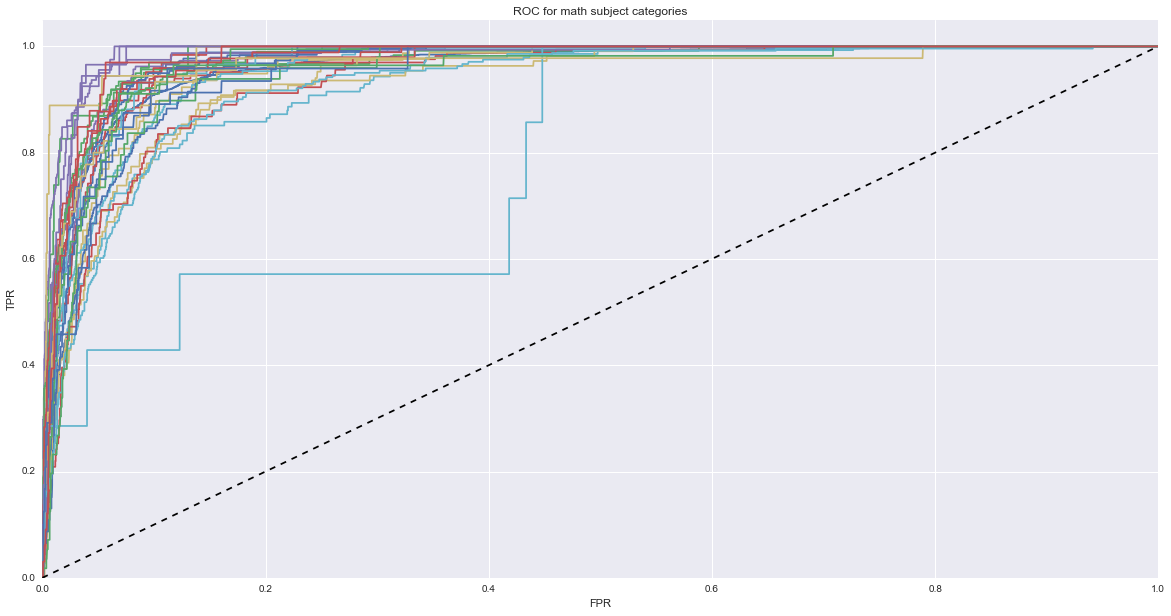

CPU times: user 17min 37s, sys: 22.8 s, total: 18min
Wall time: 18min 58s
Parser   : 336 ms


In [4]:
%%time

# Binarize the output
binary_targets = label_binarize(targets, classes=math_df['label'].unique())
n_classes = binary_targets.shape[1]
class_labels = math_df['label'].unique()

# shuffle and split training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(text_data, binary_targets, test_size=.33,
                                                    random_state=0)


M_train1 = tfidf_model.transform(X_train1)
M_test1 = tfidf_model.transform(X_test1)
# Learn to predict each class against the other
classifier = OneVsRestClassifier(LogisticRegression(C=1, penalty='l2'), n_jobs=-1)
y_score = classifier.fit(M_train1, y_train1).decision_function(M_test1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test1[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test1.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
# plt.figure()
# plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC example')
# plt.legend(loc="lower right")
# #plt.show()

# Plot ROC curve
plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC for math subject categories')
#plt.legend(loc="lower right")
plt.show()

Look at the different AUCs

In [7]:
#Get the AUC values
for ix in xrange(len(class_labels)):
    roc_auc[ix] = roc_auc[ix], class_labels[ix]
L = [roc_auc[key] for key in roc_auc]
L.pop()
K = sorted(L, key=lambda x: x[0])

In [8]:
vals = [(0.7907899593946105, u'GM'),
 (0.92534874366083875, u'DS'),
 (0.92696399523300022, u'MP'),
 (0.92995471064453061, u'CA'),
 (0.93802081053077069, u'RT'),
 (0.9402593100837553, u'FA'),
 (0.9499273289887008, u'QA'),
 (0.95328455165869863, u'AG'),
 (0.95368086458995549, u'GR'),
 (0.95449762299022489, u'CO'),
 (0.95470644053299125, u'CV'),
 (0.95494513480124987, u'SP'),
 (0.95595160766482623, u'KT'),
 (0.95743198077114533, u'MG'),
 (0.96103100439383615, u'DG'),
 (0.96724592975344659, u'AT'),
 (0.9684543325526932, u'PR'),
 (0.97008272857276501, u'AC'),
 (0.97043001812528074, 'NA'),
 (0.97161189082963029, u'AP'),
 (0.97208049134940744, u'RA'),
 (0.97223940870273973, u'NT'),
 (0.97346689632357175, u'OC'),
 (0.97489069802502637, u'ST'),
 (0.97562341120929674, u'GT'),
 (0.97775145592735169, u'SG'),
 (0.98232636928289097, u'LO'),
 (0.98433279308481891, u'HO'),
 (0.98440179665169458, u'IT'),
 (0.98505821910124958, u'CT'),
 (0.98596555664381325, u'OA'),
 (0.98679092382495948, u'GN')]

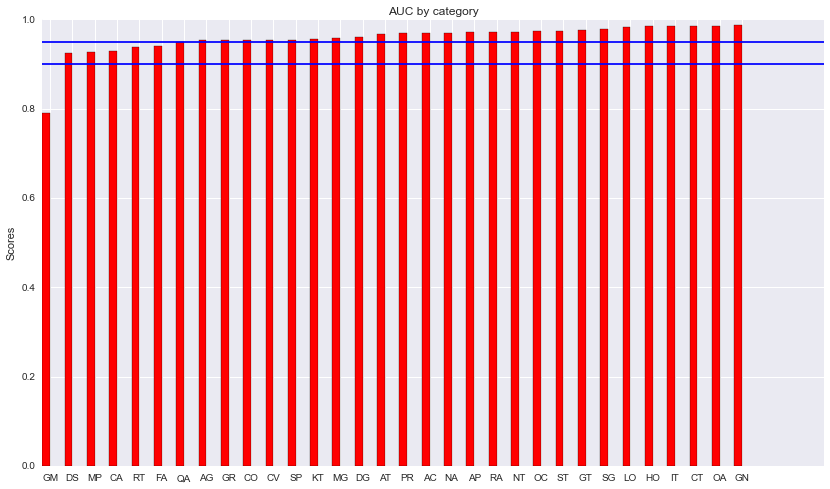

In [10]:
#Bar chart to visualize the AUC values
N = 32
aucs = []
cats = []
for ix in xrange(N):
    aucs.append(vals[ix][0])
    cats.append(vals[ix][1])



ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(14,8))
rects1 = plt.bar(ind, aucs, width, color='r')
plt.axhline(y=0.9, xmin=0)
plt.axhline(y=0.95, xmin=0)



ax.set_ylabel('Scores')
ax.set_title('AUC by category')
ax.set_xticks(ind+width)
ax.set_xticklabels(cats)

plt.savefig('auc.jpg')

Now for some heatmaps

In [11]:
#Make my own k-folds for cross-validation so I can recover all the necessary info
fold = StratifiedKFold(targets, n_folds=5, shuffle=True)
training_data = []
training_targets = []
testing_data = []
testing_targets = []
for x, y in fold:
    training_data.append(text_data[x])
    training_targets.append(targets[x])
    testing_data.append(text_data[y])
    testing_targets.append(targets[y])

In [13]:
#Build/train/test a model on each fold and recover the mis-classification rates
#This one takes quite a while with so many tfidf models to build

Heats = []
for ix in range(5):
    tfidf_kfold = TfidfVectorizer(max_features=5000, stop_words=math_stop(), \
                        ngram_range=(1, 2), decode_error='ignore')
    M_kfold = tfidf_kfold.fit_transform(training_data[ix])
    M_test_kfold = tfidf_kfold.transform(testing_data[ix])
    ovr = OneVsRestClassifier(LogisticRegression(C=1, penalty='l2'), n_jobs=-1)
    ovr.fit(M_kfold, training_targets[ix])
    preds = ovr.predict(M_test_kfold)

    Heat = np.zeros(32 * 32).reshape(32,32)
    Heat_df = pd.DataFrame(Heat, index=class_labels, columns=class_labels)
    for label in class_labels:
        mask = np.where(testing_targets[ix]==label)
        counts = Counter(preds[mask])
        for other_label in class_labels:
            Heat_df[label][other_label] = counts[other_label] 
    Heats.append(Heat_df)
heat_df = Heats[0]+Heats[1]+Heats[2]+Heats[3]+Heats[4]

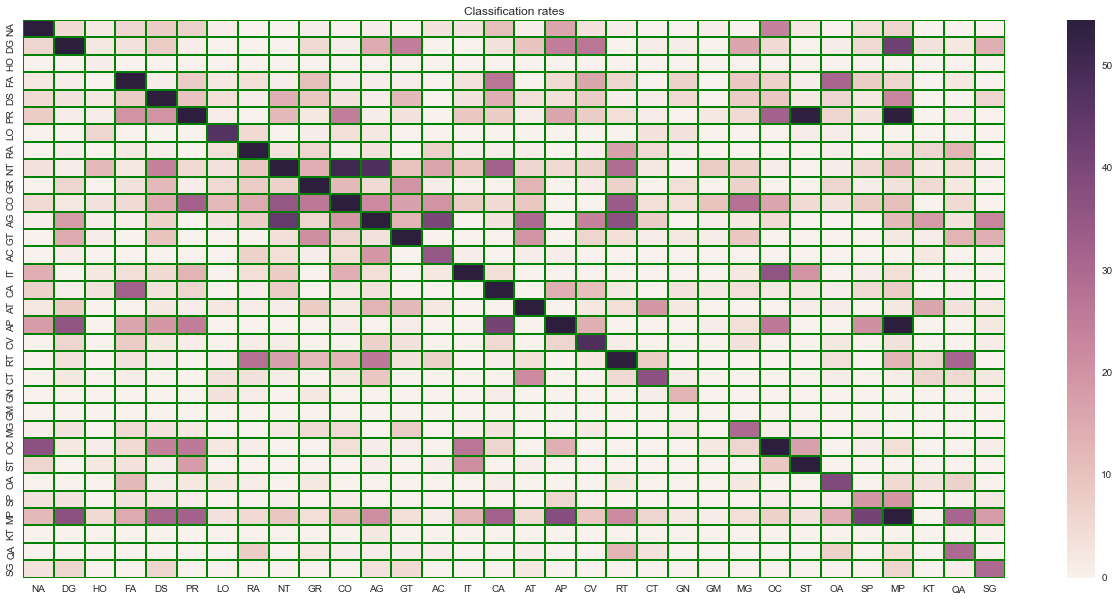

In [18]:
#Now make the heatmap

plt.figure(figsize=(22,10))
ax = sns.heatmap(heat_df, annot=False, linewidths=1, robust=True, linecolor='green')
plt.title('Classification rates')
plt.show()

One more heat map, using the average distance between categories

In [22]:
N = M.todense()
masks = pd.DataFrame(data=N)

Tar = pd.DataFrame(data=targets, columns=['label'])

result = pd.concat([masks, Tar], axis=1)

grouped = result.groupby('label').mean()

Category_distances = np.zeros(32 * 32).reshape(32,32)

Cat_dists = pd.DataFrame(Category_distances, index=class_labels, columns=class_labels)
for label in class_labels:
    for other_label in class_labels:
        Cat_dists[label][other_label] = np.around(cosine(grouped.loc[label].values, grouped.loc[other_label].values),3)

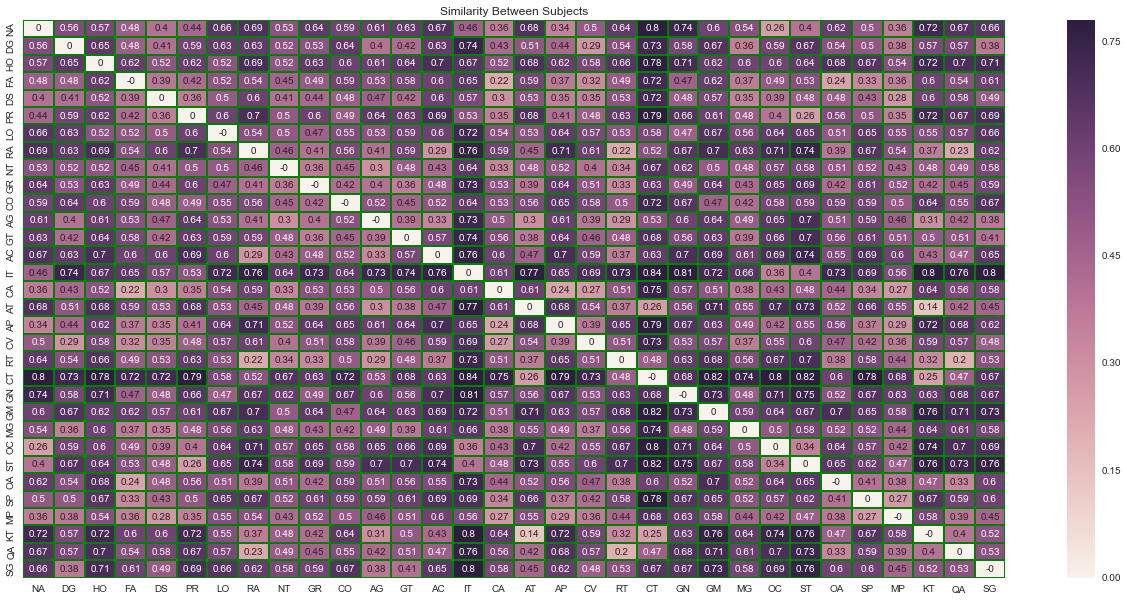

In [23]:
plt.figure(figsize=(22,10))
ax = sns.heatmap(Cat_dists, annot=True, linewidths=1, robust=True, linecolor='green')
plt.title('Similarity Between Subjects')
plt.show()